In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import seaborn as sn
import pandas as pd
from scipy.io import loadmat
from sklearn.metrics import confusion_matrix
from esn import ESN

In [2]:
# 音声信号を前処理したデータ(コクリアグラム)の読み込み
def read_speech_data(dir_name, utterance_train_list):

    # .matファイルのみを取得
    data_files = glob.glob(os.path.join(dir_name, '*.mat'))

    # データに関する情報
    n_channel = 77  # チャネル数
    n_label = 10  # ラベル数(digitの数)

    # 初期化
    train_input = np.empty((0, n_channel))  # 教師入力
    train_output = np.empty((0, n_label))  # 教師出力
    train_length = np.empty(0, np.int)  # データ長
    train_label = np.empty(0, np.int)  # 正解ラベル
    test_input = np.empty((0, n_channel))  # 教師入力
    test_output = np.empty((0, n_label))  # 教師出力
    test_length = np.empty(0, np.int)  # データ長
    test_label = np.empty(0, np.int)  # 正解ラベル
    
    # データ読み込み
    for each_file in data_files:
        data = loadmat(each_file)
        utterance = int(each_file[-8])  # 各speakerの発話番号
        digit = int(each_file[-5]) # 発話された数字
        if utterance in utterance_train_list:  # 訓練用
            # 入力データ（構造体'spec'に格納されている）
            train_input = np.vstack((train_input, data['spec'].T))
            # 出力データ（n_tau x 10，値はすべて'-1'）
            tmp = np.zeros([data['spec'].shape[1], 10])
            tmp[:, digit] = 1  # digitの列のみ1
            train_output = np.vstack((train_output, tmp))
            # データ長
            train_length = np.hstack((train_length, data['spec'].shape[1]))
            # 正解ラベル
            train_label = np.hstack((train_label, digit))
        else:  # 検証用
            # 入力データ（構造体'spec'に格納されている）
            test_input = np.vstack((test_input, data['spec'].T))
            # 出力データ（n_tau x 10，値はすべて'-1'）
            tmp = np.zeros([data['spec'].shape[1], 10])
            tmp[:, digit] = 1  # digitの列のみ1
            test_output = np.vstack((test_output, tmp))
            # データ長
            test_length = np.hstack((test_length, data['spec'].shape[1]))
            # 正解ラベル
            test_label = np.hstack((test_label, digit))

    return train_input, train_output, train_length, train_label, test_input, test_output, test_length, test_label

In [3]:
n_label = 10
train_list = [1, 2, 3, 4, 5]
train_input, train_output, train_length, train_label, test_input, test_output, test_length, test_label = read_speech_data(dir_name='data/Lyon_decimation_128', utterance_train_list=train_list)

C:\Users\yoshi\AppData\Local\Temp\ipykernel_14696\1287193571.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_length = np.empty(0, np.int)  # データ長
C:\Users\yoshi\AppData\Local\Temp\ipykernel_14696\1287193571.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rel

In [4]:
# 入力層
N_u = 77
N_x = 1000
input_scale = 1
rec_scale = 1.0
rho = 0.9
leaking_rate = 1
activation_func = np.tanh
seed = 0

# ESNのインスタンスを作成
esn = ESN(N_u, N_x, input_scale, rec_scale, rho, leaking_rate, activation_func, seed)

In [5]:
stateCollectMat_train = esn.compute_reservoir_states(train_input)
Wout = esn.train(stateCollectMat_train, train_output)
Y_pred_train = esn.predict(Wout, stateCollectMat_train)    
pred_train = np.array([np.argmax(np.bincount(np.argmax(Y_pred_train[:, start:start+length], axis=0))) for start, length in zip(np.cumsum([0] + list(train_length[:-1])), train_length)])    
train_WER = np.mean(pred_train != train_label)
print("訓練誤差： WER = %5.4lf" % train_WER)
cm_train = confusion_matrix(train_label, pred_train, labels=range(n_label))

stateCollectMat_test = esn.compute_reservoir_states(test_input)
Y_pred_test = esn.predict(Wout, stateCollectMat_test)
pred_test = np.array([np.argmax(np.bincount(np.argmax(Y_pred_test[:, start:start+length], axis=0))) for start, length in zip(np.cumsum([0] + list(test_length[:-1])), test_length)])
test_WER = np.mean(pred_test != test_label)
print("検証誤差： WER = %5.4lf" % test_WER)
cm_test = confusion_matrix(test_label, pred_test, labels=range(n_label))

Computing Reservoir States: 100%|███████████████████████████| 16957/16957 [00:08<00:00, 2068.16it/s]


訓練誤差： WER = 0.0000


Computing Reservoir States: 100%|███████████████████████████| 17150/17150 [00:07<00:00, 2325.94it/s]

検証誤差： WER = 0.0280


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


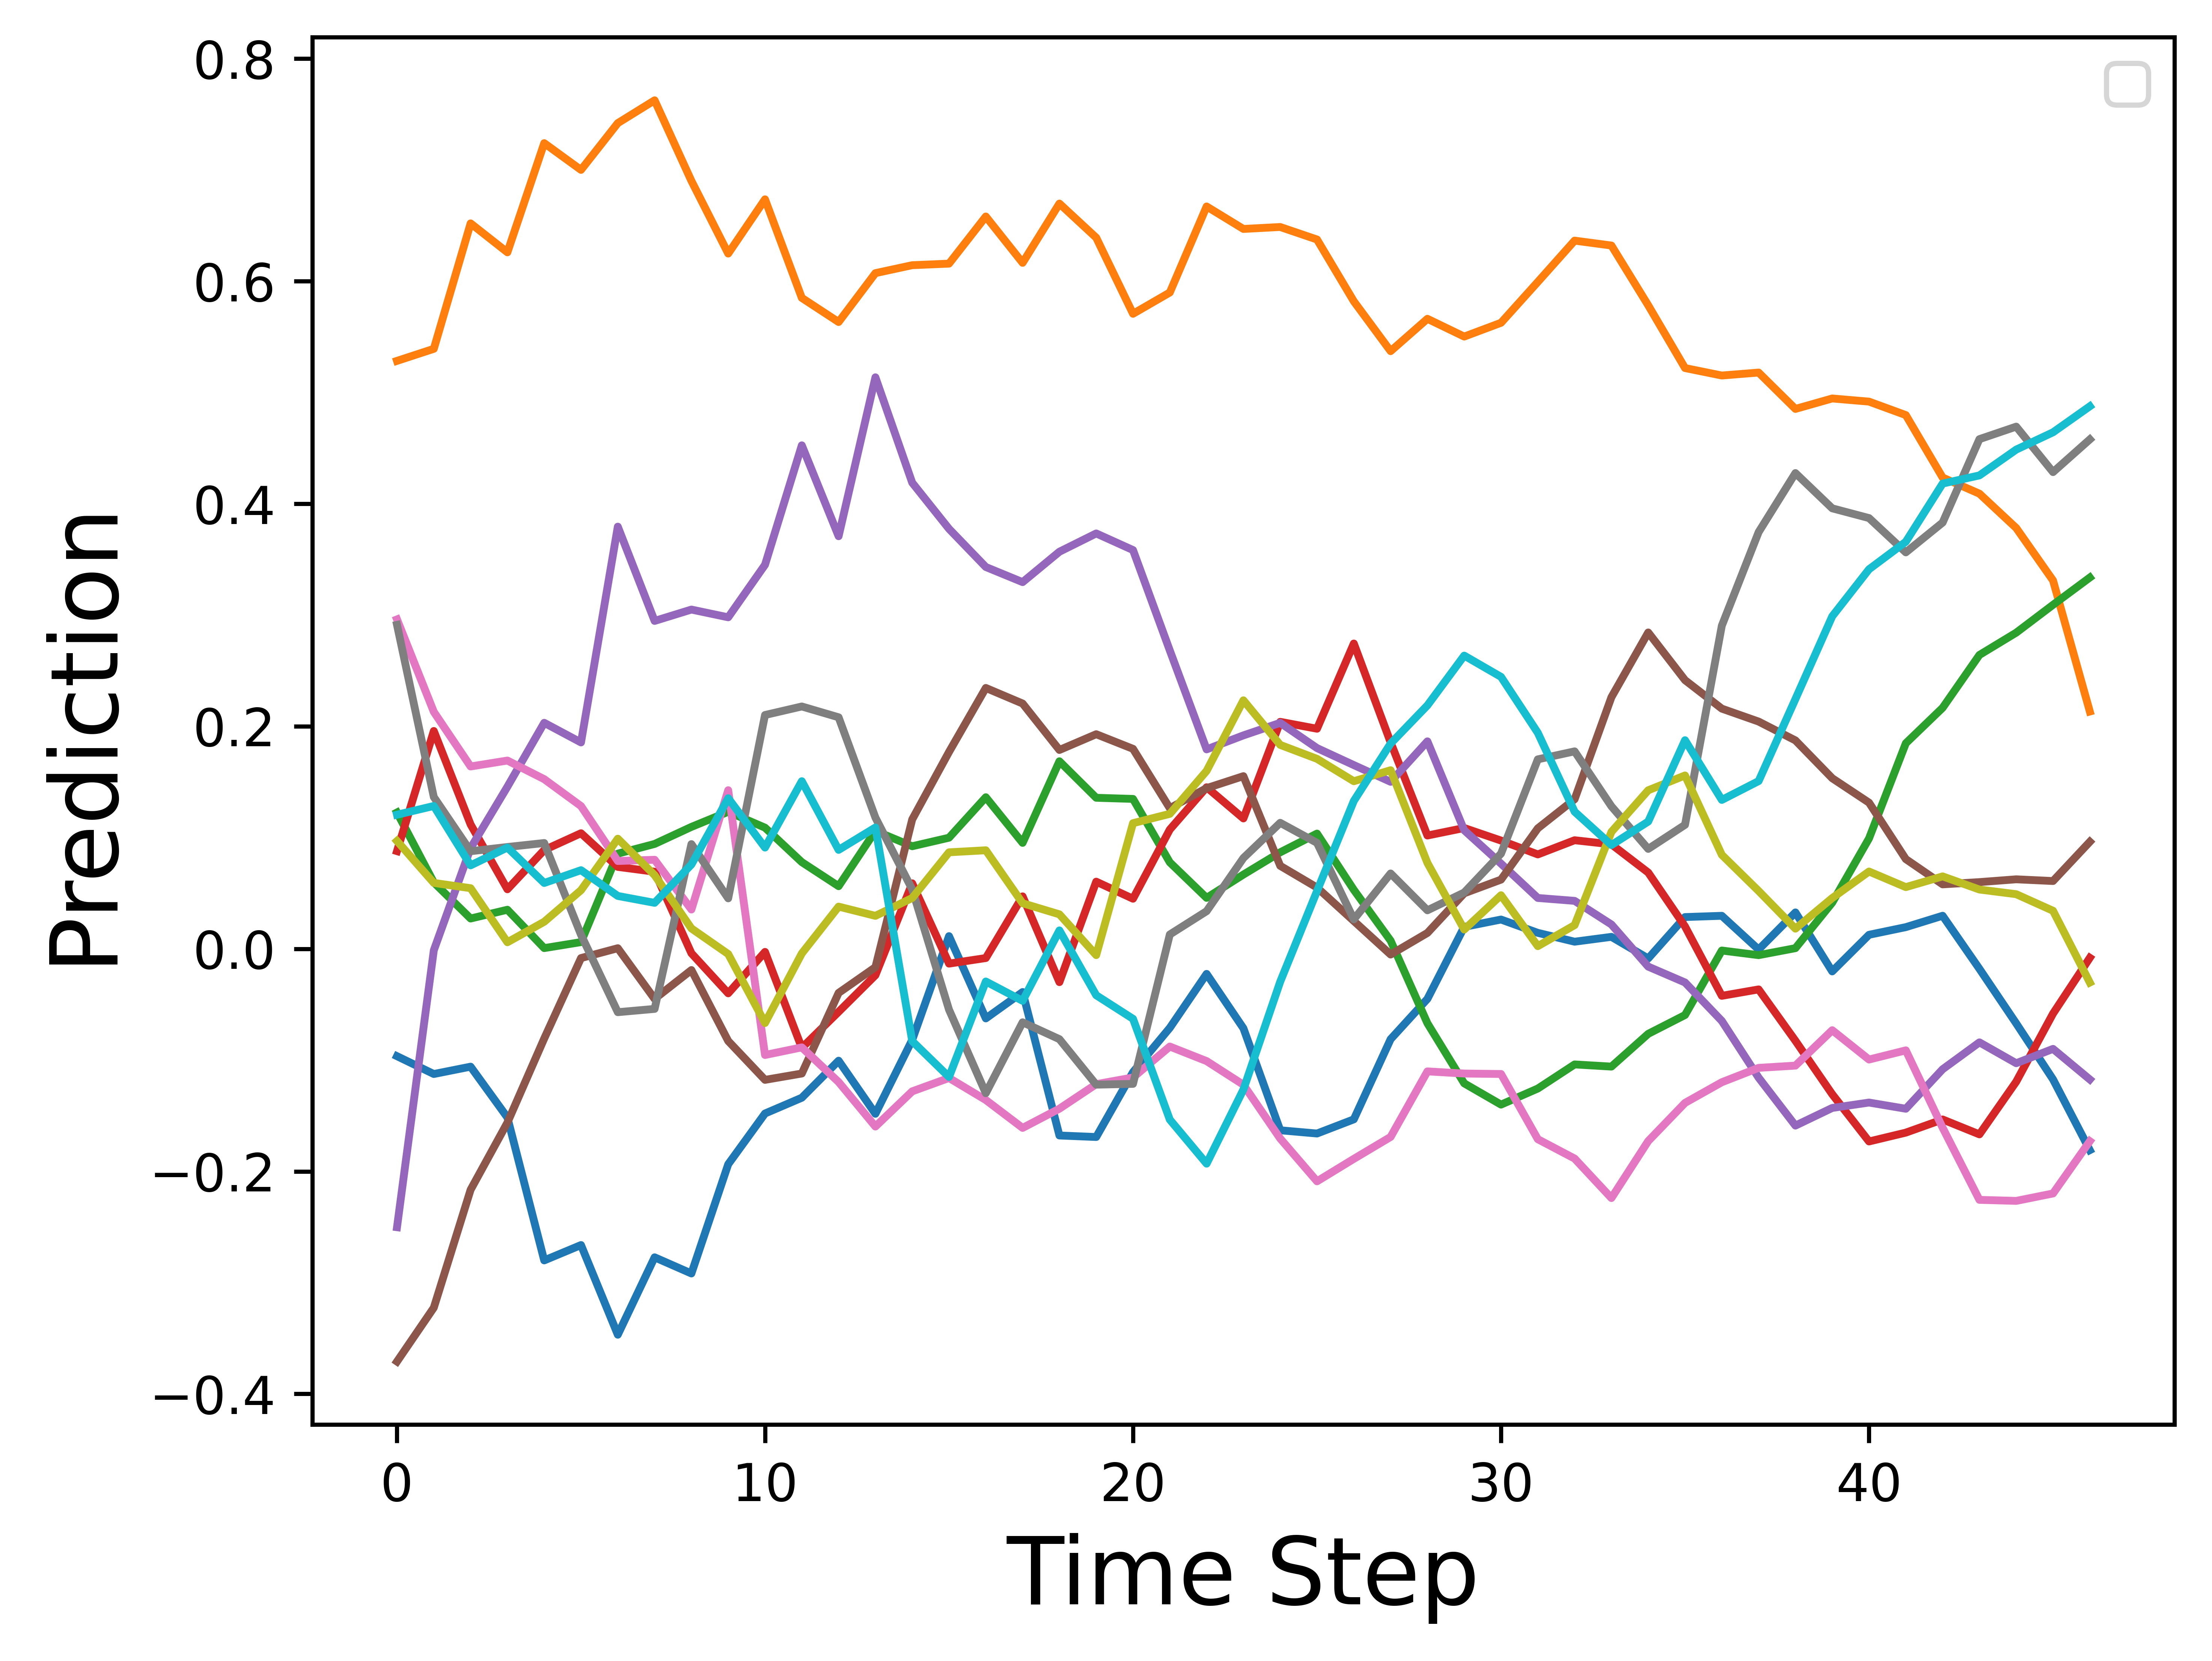

In [6]:
############################## 予測の可視化 ##############################
pred_example_data = Y_pred_test[:test_length[0], :]
pred_example_data = pred_example_data[:, 69:116]
plt.figure(dpi=1000)
plt.plot(pred_example_data.T)
plt.xlabel('Time Step', fontsize=18)
plt.ylabel('Prediction', fontsize=18)
plt.legend()
plt.show()

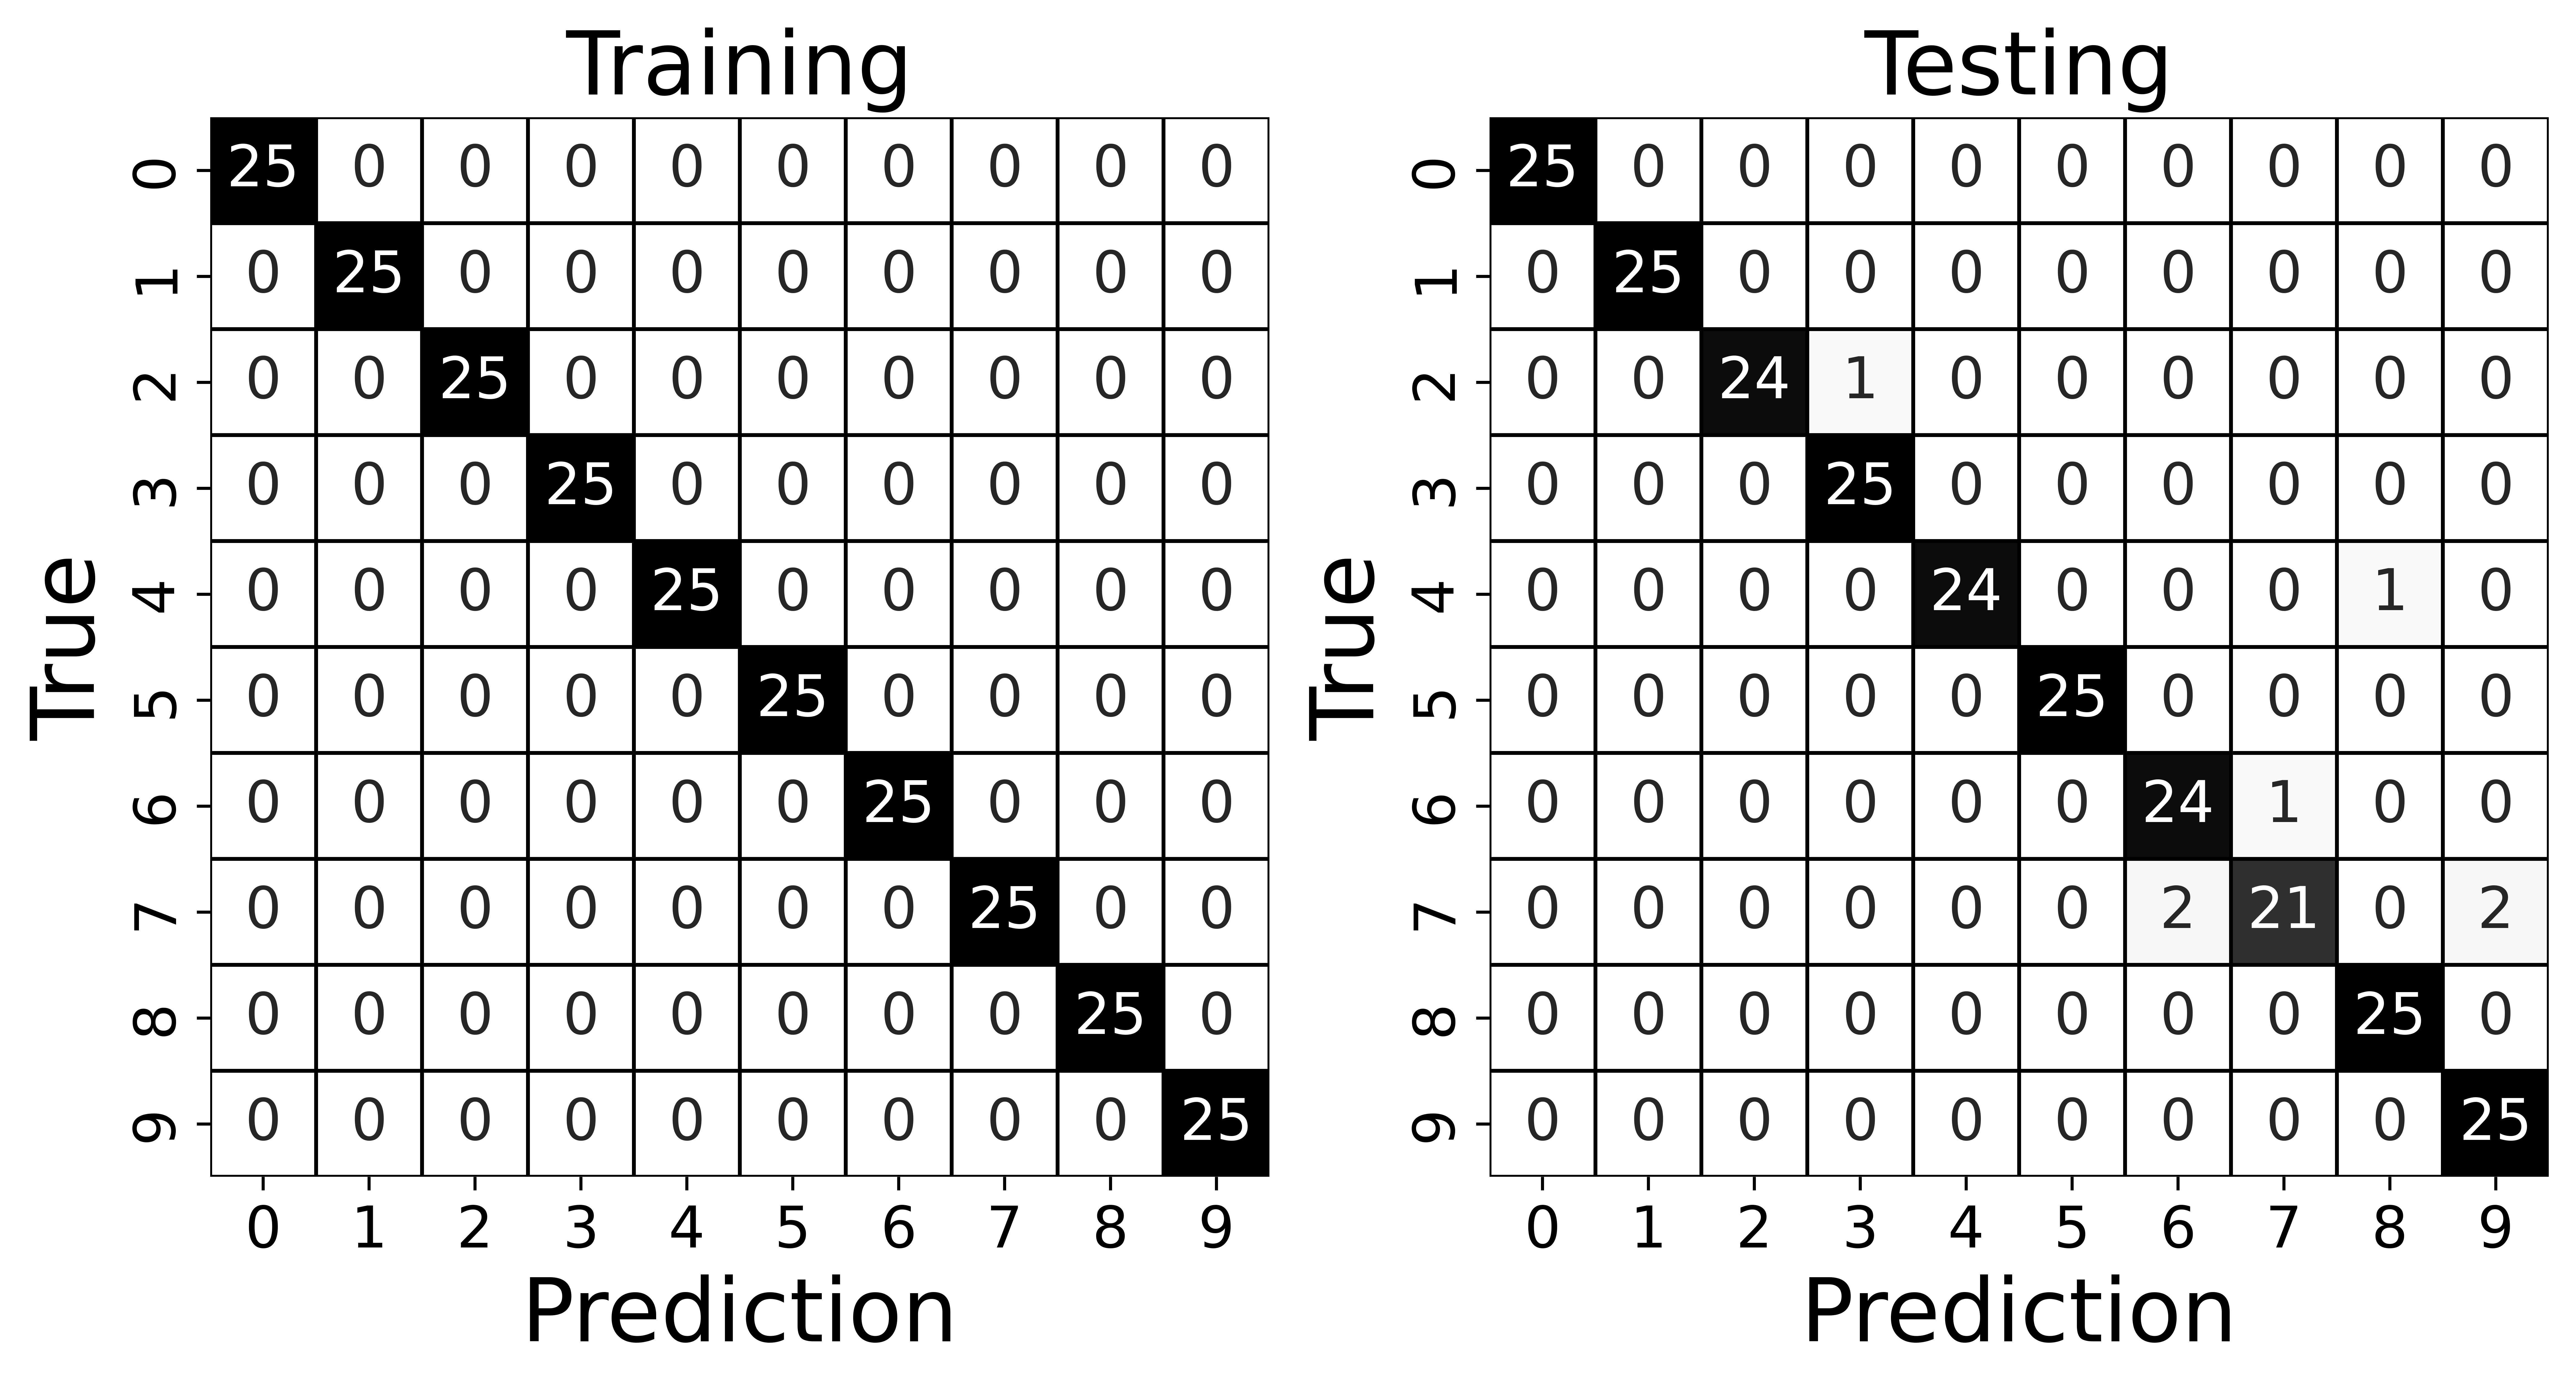

In [7]:
############################## 混同行列の表示 ##############################
plt.rcParams['font.size'] = 15
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5), dpi=1000)

sn.heatmap(pd.DataFrame(cm_train, range(n_label), range(n_label)), cmap='Greys', annot=True, linewidths=1, linecolor='black', cbar=False, square=True, ax=ax1)
ax1.set_xlabel('Prediction', fontsize=23)
ax1.set_ylabel('True', fontsize=23)
ax1.set_title('Training', fontsize=23)

sn.heatmap(pd.DataFrame(cm_test, range(n_label), range(n_label)), cmap='Greys', annot=True, linewidths=1, linecolor='black', cbar=False, square=True, ax=ax2)
ax2.set_xlabel('Prediction', fontsize=23)
ax2.set_ylabel('True', fontsize=23)
ax2.set_title('Testing', fontsize=23)

plt.show()